In [1]:
from tifffile import imread
from structured_light_tomography import photocount_treatment as pt
import matplotlib.pyplot as plt
import numpy as np
import h5py

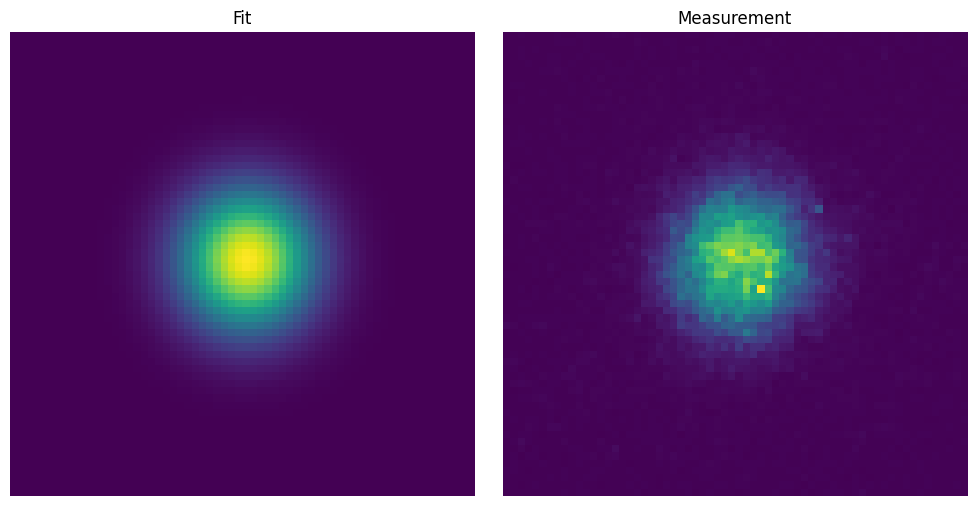

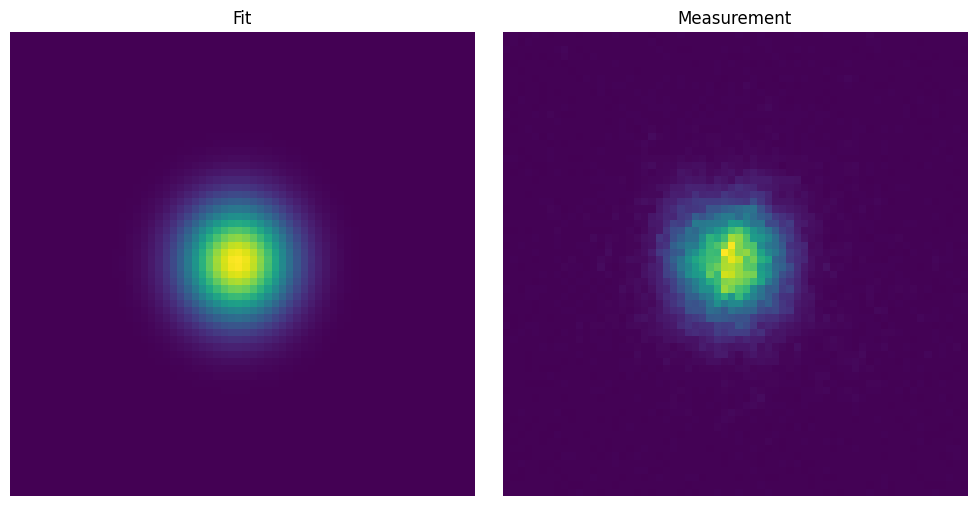

In [2]:
calibration = pt.format_image(imread('ExperimentalData/Photocount/calibration.tif'))

def display_images(img1, img2):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5)) 

    axs[0].imshow(img1) 
    axs[0].set_title('Fit')
    axs[0].axis('off')

    axs[1].imshow(img2)
    axs[1].set_title('Measurement')
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

result = pt.fit_grid(calibration[0])
display_images(pt.gaussian(result.x, calibration[0].shape), calibration[0])

result = pt.fit_grid(calibration[1])
display_images(pt.gaussian(result.x, calibration[1].shape), calibration[1])

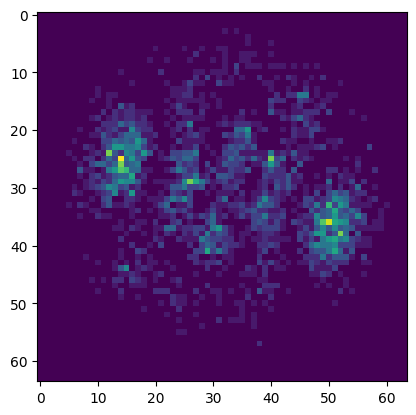

In [16]:
background = imread('ExperimentalData/Photocount/background.tif')
mean = np.mean(background, axis=0)
std = np.std(background, axis=0)

xdmin,ydmin,xdmax,ydmax = pt.fit_grid(calibration[0]).x
xcmin,ycmin,xcmax,ycmax = pt.fit_grid(calibration[1]).x

xd = np.linspace(xdmin, xdmax, calibration.shape[2])
yd = np.linspace(ydmin, ydmax, calibration.shape[1])
xc = np.linspace(xcmin, xcmax, calibration.shape[2])
yc = np.linspace(ycmin, ycmax, calibration.shape[1])

order = 4
radius = 10
frames = imread(f'ExperimentalData/Photocount/Order{order}/0.tif')
photons = pt.format_images(pt.extract_photons(frames, mean, std, 5))
pt.circular_masks(photons, radius, xd, yd, xc, yc)
plt.imshow(np.sum(photons, axis=0)[0])

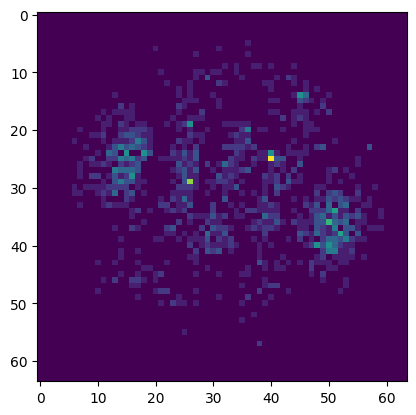

In [17]:
history = pt.history_vector(photons)
reconstructed = pt.array_representation(history[:2048], photons[0].shape)
plt.imshow(reconstructed[0])

In [18]:
idxs = range(50)
histories = np.empty((len(idxs), 2048),dtype=np.uint32)

for i in idxs:
    frames = imread(f'ExperimentalData/Photocount/Order{order}/{i}.tif')
    photons = pt.format_images(pt.extract_photons(frames, mean, std, 5))
    pt.circular_masks(photons, radius, xd, yd, xc, yc)

    histories[i] = pt.history_vector(photons)[:2048]
    

with h5py.File('ExperimentalData/Photocount/datasets.h5', 'a') as f:
    dset = f.create_dataset(f'histories_order{order}', data=histories)
    dset.attrs['shape'] = photons.shape[1:]

In [7]:
with h5py.File('ExperimentalData/Photocount/datasets.h5', 'a') as f:
    with h5py.File('ExperimentalData/Photocount/coefficients.h5') as f2:
        for order in range(1, 5):
            coeffs = f2[f'order{order}'][:50,:]
            f[f'coefficients_order{order}'] = coeffs


In [9]:
order

4

In [10]:
with h5py.File('ExperimentalData/Photocount/datasets.h5', 'r') as f:
    histories = f[f'histories_order3'][:]
    x_exp = np.float32(np.array([pt.array_representation(history,(2,64,64)) for history in histories]))

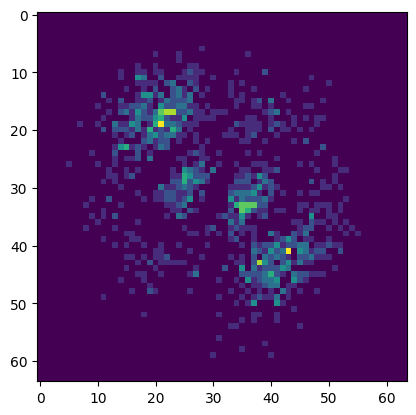

In [11]:
plt.imshow(x_exp[0,0])